In this notebook: try razor pdf with loose hyperpriors on the pdf parameters

In [1]:
import os
os.environ['THEANO_FLAGS'] = "device=cpu"

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import theano as th
import theano.tensor as T
import pymc3 as pm
import pickle
import csv
from statistics import median
from mpl_toolkits.mplot3d import axes3d

th.config.compute_test_value = 'ignore'

In [2]:
# Get the data
boxes = ['MultiJet', 'DiJet', 'LeptonMultiJet', 'LeptonJet']
sideband_x = {'MultiJet':650, 'DiJet':650, 'LeptonMultiJet':550, 'LeptonJet':550}
sideband_y = {'MultiJet':0.3, 'DiJet':0.3, 'LeptonMultiJet':0.2, 'LeptonJet':0.2}
btag_max = {'MultiJet':3, 'DiJet':2, 'LeptonMultiJet':3, 'LeptonJet':2}
data = { box:pd.read_csv("data/RazorFitInstance_Razor2016_MoriondRereco_{}.csv".format(box), index_col='NBtags')
           for box in boxes }
sideband_data = { box:data[box][ (data[box]['MR'] < sideband_x[box]) | (data[box]['Rsq'] < sideband_y[box]) ]
                    for box in boxes}

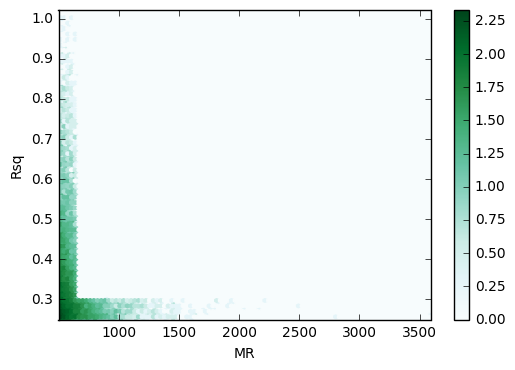

In [3]:
# Check the data
ax = sideband_data['MultiJet'].plot(kind='hexbin', x='MR', y='Rsq', bins='log', sharex=False);
plt.show()

In [4]:
class Sideband(object):
    """Class storing razor sideband geometry info."""
    def __init__(self, MRMin=500, MRMax=4000, RsqMin=0.25, RsqMax=1.5, 
                MRSidebandMax=650, RsqSidebandMax=0.30):
        self.MRMin = T.as_tensor_variable(MRMin)
        self.MRMax = T.as_tensor_variable(MRMax)
        self.RsqMin = T.as_tensor_variable(RsqMin)
        self.RsqMax = T.as_tensor_variable(RsqMax)
        self.MRSidebandMax = T.as_tensor_variable(MRSidebandMax)
        self.RsqSidebandMax = T.as_tensor_variable(RsqSidebandMax)
        
        # as floats
        self.MRMin_ = MRMin
        self.MRMax_ = MRMax
        self.RsqMin_ = RsqMin
        self.RsqMax_ = RsqMax
        self.MRSidebandMax_ = MRSidebandMax
        self.RsqSidebandMax_ = RsqSidebandMax
        
    def in_sideband(self, MR, Rsq):
        not_in = ( (MR < self.MRMin) + (MR > self.MRMax) + (Rsq < self.RsqMin) + (Rsq > self.RsqMax) 
                  + ((MR > self.MRSidebandMax)*(Rsq > self.RsqSidebandMax)) )
        return not_in < 1
        
hadronic_sideband = Sideband(500, 4000, 0.25, 1.5, 650, 0.30)
leptonic_sideband = Sideband(400, 4000, 0.15, 1.5, 550, 0.20)

hadronic_mr_sideband = Sideband(500, 650, 0.25, 1.5, 650, 1.5)
hadronic_rsq_sideband = Sideband(500, 4000, 0.25, 0.30, 4000, 0.30)

leptonic_mr_sideband = Sideband(400, 550, 0.15, 1.5, 550, 1.5)
leptonic_rsq_sideband = Sideband(400, 4000, 0.15, 0.20, 4000, 0.20)

In [5]:
def razor_p(MR, Rsq, P, n, A, B, MRMin, RsqMin):
    """Computes razor probability density (numpy version)."""
    term1 = P * np.power((MR-MRMin+A)/A * (Rsq-RsqMin+B)/B, 1./n)
    prob = np.exp(-term1) 
    return prob

def razor_int(P, n, A, B, MRMin, MRMax, RsqMin, RsqMax, sideband):
    """Computes razor integral in a rectangular region"""
    func = lambda y, x: razor_p(x, y, P, n, A, B, sideband.MRMin_, sideband.RsqMin_)
    RsqLow = lambda x: RsqMin
    RsqHigh = lambda x: RsqMax
    return sp.integrate.dblquad(func, MRMin, MRMax, RsqLow, RsqHigh)[0]

def razor_norm(P, n, A, B, sideband):
    norm_MR_sideband = razor_int(P, n, A, B, sideband.MRMin_, sideband.MRSidebandMax_, 
                                          sideband.RsqMin_, sideband.RsqMax_, sideband)
    norm_Rsq_sideband = razor_int(P, n, A, B, sideband.MRSidebandMax_, sideband.MRMax_, 
                                          sideband.RsqMin_, sideband.RsqSidebandMax_, sideband)
    return norm_MR_sideband + norm_Rsq_sideband

def razor_p_sidebandnormalized(MR, Rsq, P, n, A, B, nevents, sideband=hadronic_sideband):
    """Returns probability normalized to the given number of events in the given sideband"""
    p = razor_p(MR, Rsq, P, n, A, B, sideband.MRMin_, sideband.RsqMin_)
    norm = razor_norm(P, n, A, B, sideband)
    return nevents*p/norm

In [6]:
# Using scipy's integration functionality we can directly compute the razor pdf integral numerically.
# This may allow us to move to pdfs whose norm is not analytically calculable.  

class RazorIntegral(th.Op):
    """Inputs: P, n1, n2, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin
       Output: pdf integral"""
    __props__ = ()
    epsilon = 1e-7
    
    def make_node(self, *inputs):
        inputs = [T.as_tensor_variable(inp) for inp in inputs]
        output = T.dscalar()
        return th.Apply(self, inputs, [output])
    
    def perform(self, node, inputs, output_storage):
        P, n, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin = inputs
        func = lambda y, x: razor_p(x, y, P, n, A, B, sidebandMRMin, sidebandRsqMin)
        RsqLow = lambda x: RsqMin
        RsqHigh = lambda x: RsqMax
        pdf_integral = sp.integrate.dblquad( func, MRMin, MRMax, RsqLow, RsqHigh )[0]
        
        res = output_storage[0]
        res[0] = np.array(pdf_integral)
        
    def grad(self, inputs, g):
        P, n, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin = inputs
        out_grad = g[0]
        e = self.epsilon
        P_grad = (razor_integral(P + e, n, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P - e, n, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        n_grad = (razor_integral(P, n + e, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P, n - e, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        A_grad = (razor_integral(P, n, A + e, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P, n, A - e, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        B_grad = (razor_integral(P, n, A, B + e, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P, n, A, B - e, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        MRMin_grad = MRMin.zeros_like()
        MRMax_grad = MRMax.zeros_like()
        RsqMin_grad = RsqMin.zeros_like()
        RsqMax_grad = RsqMax.zeros_like()
        sidebandMRMin_grad = sidebandMRMin.zeros_like()
        sidebandRsqMin_grad = sidebandRsqMin.zeros_like()
        return [out_grad * gr for gr in [P_grad, n_grad, A_grad, B_grad, 
                                         MRMin_grad, MRMax_grad, RsqMin_grad, RsqMax_grad,
                                         sidebandMRMin_grad, sidebandRsqMin_grad]]
        
razor_integral = RazorIntegral()

In [7]:
# Create PyMC3 class for razor PDF
from pymc3.distributions import Continuous
from pymc3.distributions.dist_math import bound

class Razor(Continuous):
    def __init__(self, P, n, A, B, sideband, **kwargs):
        super(Razor, self).__init__(**kwargs)
        self.P = P
        self.n = n
        self.A = A
        self.B = B
        self.sideband = sideband
    
    def norm(self):
        P = self.P
        n = self.n
        A = self.A
        B = self.B
        norm_MR_sideband = razor_integral(P, n, A, B, self.sideband.MRMin, self.sideband.MRSidebandMax, 
                                          self.sideband.RsqMin, self.sideband.RsqMax, self.sideband.MRMin, self.sideband.RsqMin)
        norm_Rsq_sideband = razor_integral(P, n, A, B, self.sideband.MRSidebandMax, self.sideband.MRMax, 
                                          self.sideband.RsqMin, self.sideband.RsqSidebandMax, self.sideband.MRMin, self.sideband.RsqMin)
        return norm_MR_sideband + norm_Rsq_sideband

    def logp(self, values):
        MR = values[:,0]
        Rsq = values[:,1]
        P = self.P
        n = self.n
        A = self.A
        B = self.B
        MRMin = self.sideband.MRMin
        RsqMin = self.sideband.RsqMin
        
        term1 = P * T.pow( (MR-MRMin+A)/A * (Rsq-RsqMin+B)/B, 1./n )
        logprob = (-term1)
        lognorm = T.log(self.norm())
        return bound(logprob - lognorm, A>0, B>0, P>0, n>0.)

In [9]:
# Get nsigma values in every sideband bin

bins_hadronic = ([500, 575, 650, 750, 900, 1200, 1600, 2500, 4000], [0.25,0.30,0.41,0.52,0.64,1.5])
bins_leptonic = ([400, 475, 550, 700, 900, 1200, 1600, 2500, 4000], [0.15,0.20,0.25,0.30,0.41,0.52,0.64,1.5])

def get_data_yield(d, bin_coords):
    mrmin, mrmax, rsqmin, rsqmax = bin_coords
    return len(d[ (d['MR'] > mrmin) & (d['MR'] < mrmax) & (d['Rsq'] > rsqmin) & (d['Rsq'] < rsqmax) ])

def get_pred_yields(trace, bin_coords, sband, norm):
    mrmin, mrmax, rsqmin, rsqmax = bin_coords
    yields = []
    for i in range(len(trace)):
        P = trace['P'][i]
        n = trace['n'][i]
        A = trace['A'][i]
        B = trace['B'][i]
        full_int = razor_norm(P, n, A, B, sband)
        yields.append( razor_int(P, n, A, B, mrmin, mrmax, rsqmin, rsqmax, sband)*norm/full_int )
    return np.array(yields)

def get_nsigma(obs, preds):
    central_pred = median(preds)
    total = float(len(preds))
    if obs > central_pred:
        cdf = 1 - len(preds[preds > obs])/total
    else:
        cdf = len(preds[preds < obs])/total
    print obs, central_pred, sp.stats.iqr(preds), cdf
    return sp.stats.norm.ppf(cdf)

def get_nsigmas(trace, d, box):
    bins = bins_hadronic
    sband = hadronic_sideband
    if 'Lepton' in box:
        bins = bins_leptonic
        sband = leptonic_sideband
    norm = len(d)
    nsigmas = {}
    for ix, mrlow in enumerate(bins[0][:-1]):
        mrhigh = bins[0][ix+1]
        # only consider bins in sideband (2 bins in MR, 1 in Rsq)
        if ix < 2:
            iymax = len(bins[1])-1
        else:
            iymax = 1
        for iy, rsqlow in enumerate(bins[1][:iymax]):
            rsqhigh = bins[1][iy+1]
            this_bin = (mrlow, mrhigh, rsqlow, rsqhigh)
            this_yield = get_data_yield(d, this_bin)
            this_preds = get_pred_yields(trace, this_bin, sband, norm)
            nsigmas[this_bin] = get_nsigma(this_yield, this_preds)
    return nsigmas

In [12]:
# Model setup and training

def build_model(data, nbtags, box='MultiJet',
               prior_slopes=[0.05, 0.04, 0.04, 0.0005, 0.5],
               initial_vals=[7.0, 6.3, 6.3, 1000., 0.8],
               sideband=None):
    """Create PyMC3 model with razor pdf and observed data.
        prior_slopes: slopes for the exponential priors on P, n, A, B
        initial_vals: test values for parameters"""
    with pm.Model() as model:
        # PDF variables
        hyper_P = pm.Gamma("hyper_P", mu=prior_slopes[0], sd=100*prior_slopes[0], testval=prior_slopes[0])
        hyper_n = pm.Gamma("hyper_n", mu=prior_slopes[1], sd=100*prior_slopes[1], testval=prior_slopes[1])
        hyper_A = pm.Gamma("hyper_A", mu=prior_slopes[2], sd=100*prior_slopes[2], testval=prior_slopes[2])
        hyper_B = pm.Gamma("hyper_B", mu=prior_slopes[3], sd=100*prior_slopes[3], testval=prior_slopes[3])

        P = pm.Exponential("P", hyper_P, testval=initial_vals[0])
        n = pm.Exponential("n", hyper_n, testval=initial_vals[1])        
        A = pm.Exponential("A", hyper_A, testval=initial_vals[2])
        B = pm.Exponential("B", hyper_B, testval=initial_vals[3])
            
        if sideband is not None:
            sband = sideband
        elif box in ['LeptonJet','LeptonMultiJet']:
            sband = leptonic_sideband
        else:
            sband = hadronic_sideband
            
        observed = data.ix[nbtags][['MR','Rsq']].values
        razor_pdf = Razor("razor_pdf", P=P, n=n, A=A, B=B, sideband=sband,
                          shape=len(observed), observed=observed)
    return model

def fit_model(model, samples=10000, burn_period=5000):
    """Fit the model and return
        samples from the posterior"""
    with model:
        step = pm.Metropolis()
        trace = pm.sample(samples, step=step)
        burned_trace = trace[burn_period:]
    return burned_trace
    
def visualize_trace(trace):
    varnames = ['P','n','A','B']
    varnames += ['hyper_{}'.format(v) for v in varnames]
    # Visualize posteriors and MCMC traces
    pm.plots.traceplot(trace=trace, varnames=varnames);
    plt.show()
    # Plot the autocorrelation of the MCMC traces.
    # Long tails on this plot mean that the Markov chain is not sampling uniformly from the posterior.
    pm.plots.autocorrplot(trace=trace, varnames=varnames);
    plt.show()
    # Visualize the posteriors for the function parameters
    pm.plot_posterior(trace=trace, varnames=varnames);
    plt.show()
    
def fit_and_plot(data, nbtags, samples=10000, burn_period=5000, sideband=None, box='MultiJet'):
    """Build the model, fit it, and make diagnostic plots.
        Returns the MCMC trace."""
    model = build_model(data, nbtags, sideband=sideband, box=box)
    trace = fit_model(model, samples, burn_period)
    visualize_trace(trace)
    return trace

def save_traces(traces, fname):
    pickle.dump(traces, open(fname, "wb"))
    
def load_traces(fname):
    return pickle.load(open(fname, "rb"))

100%|██████████| 2000/2000 [03:15<00:00, 10.24it/s]


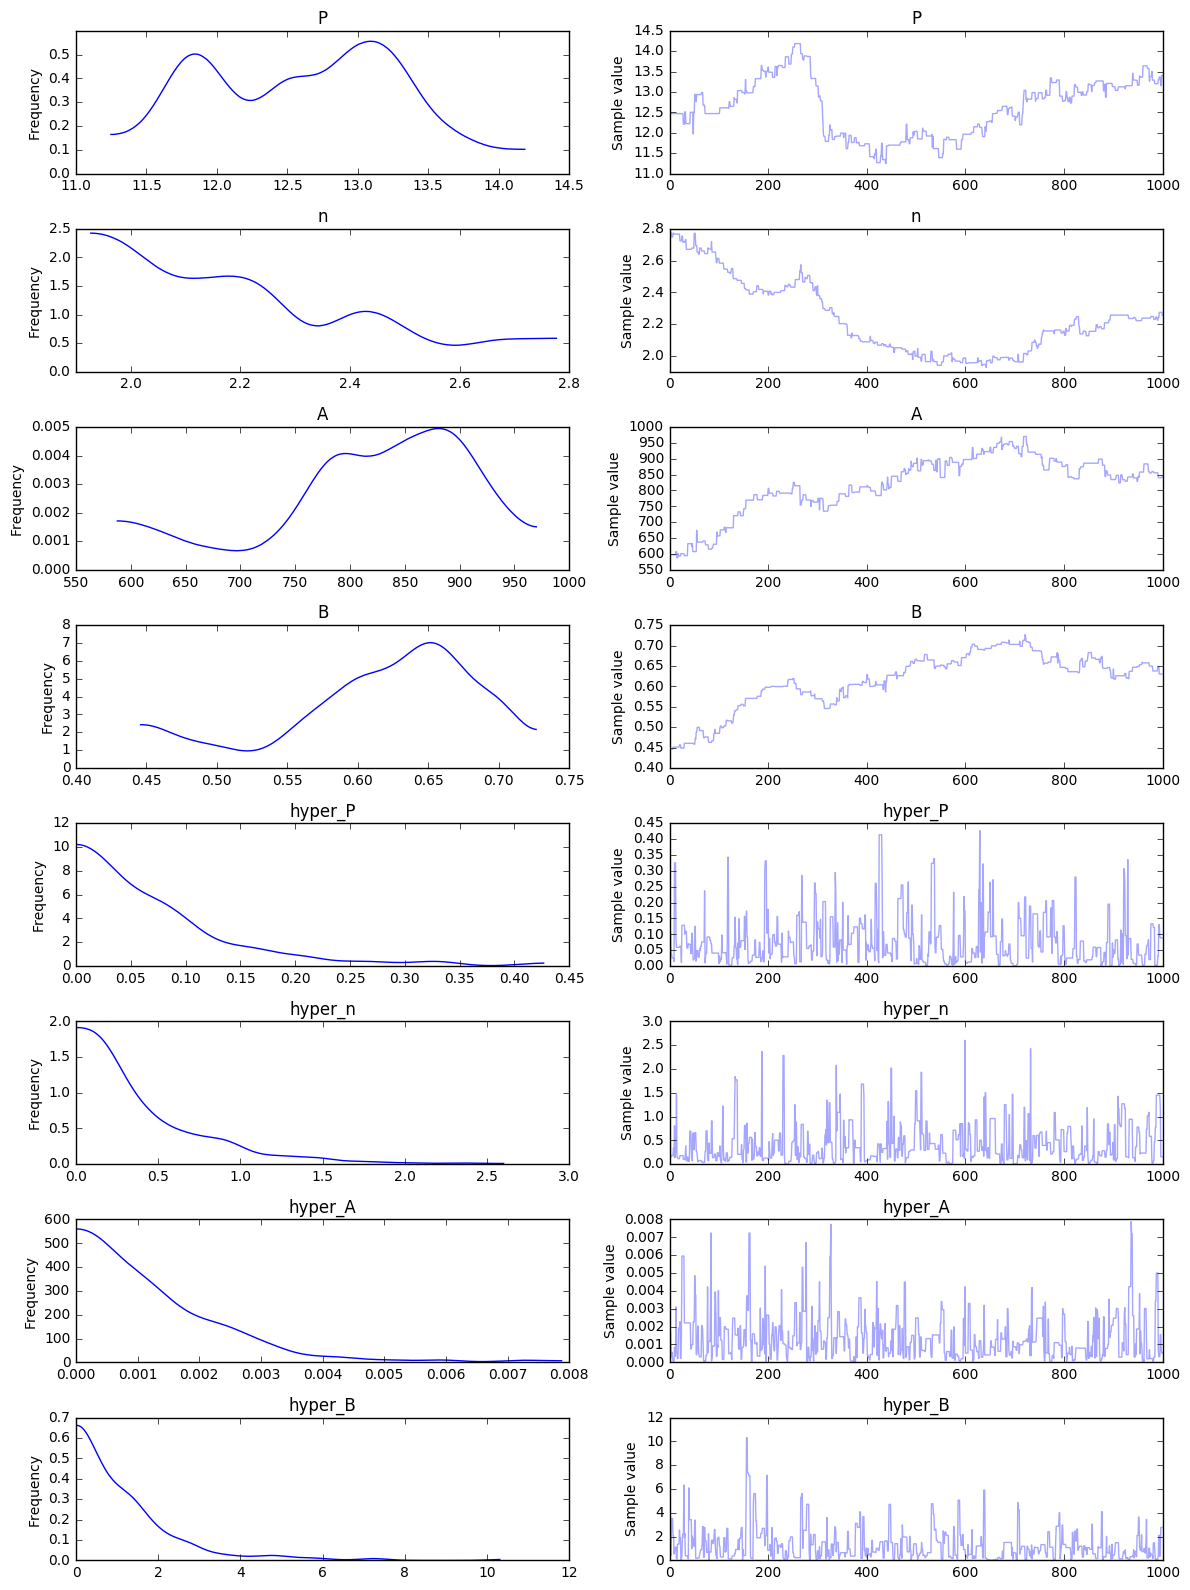

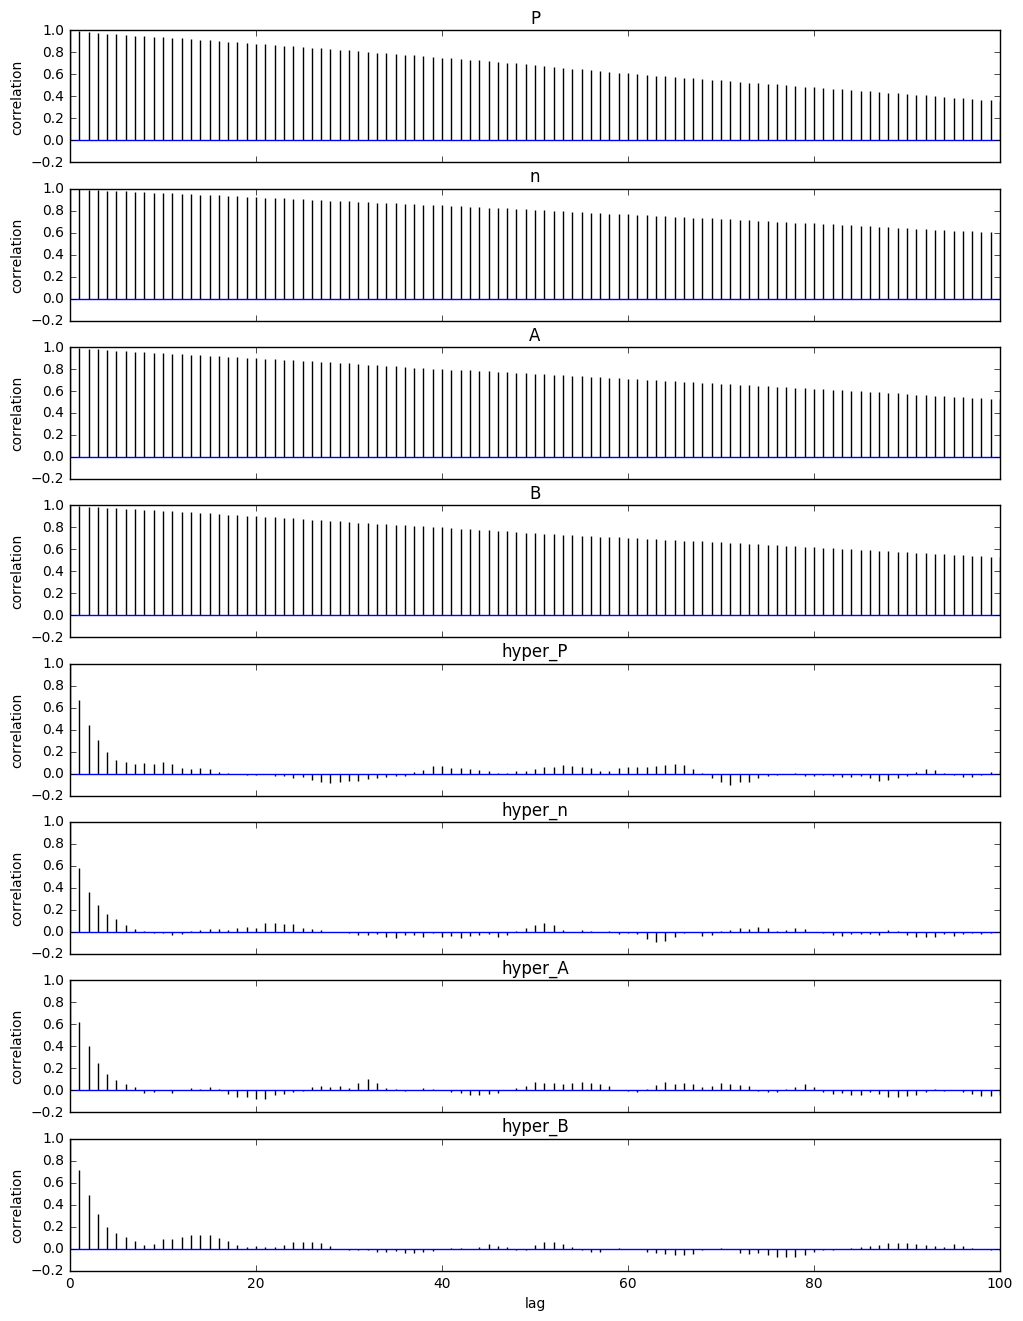

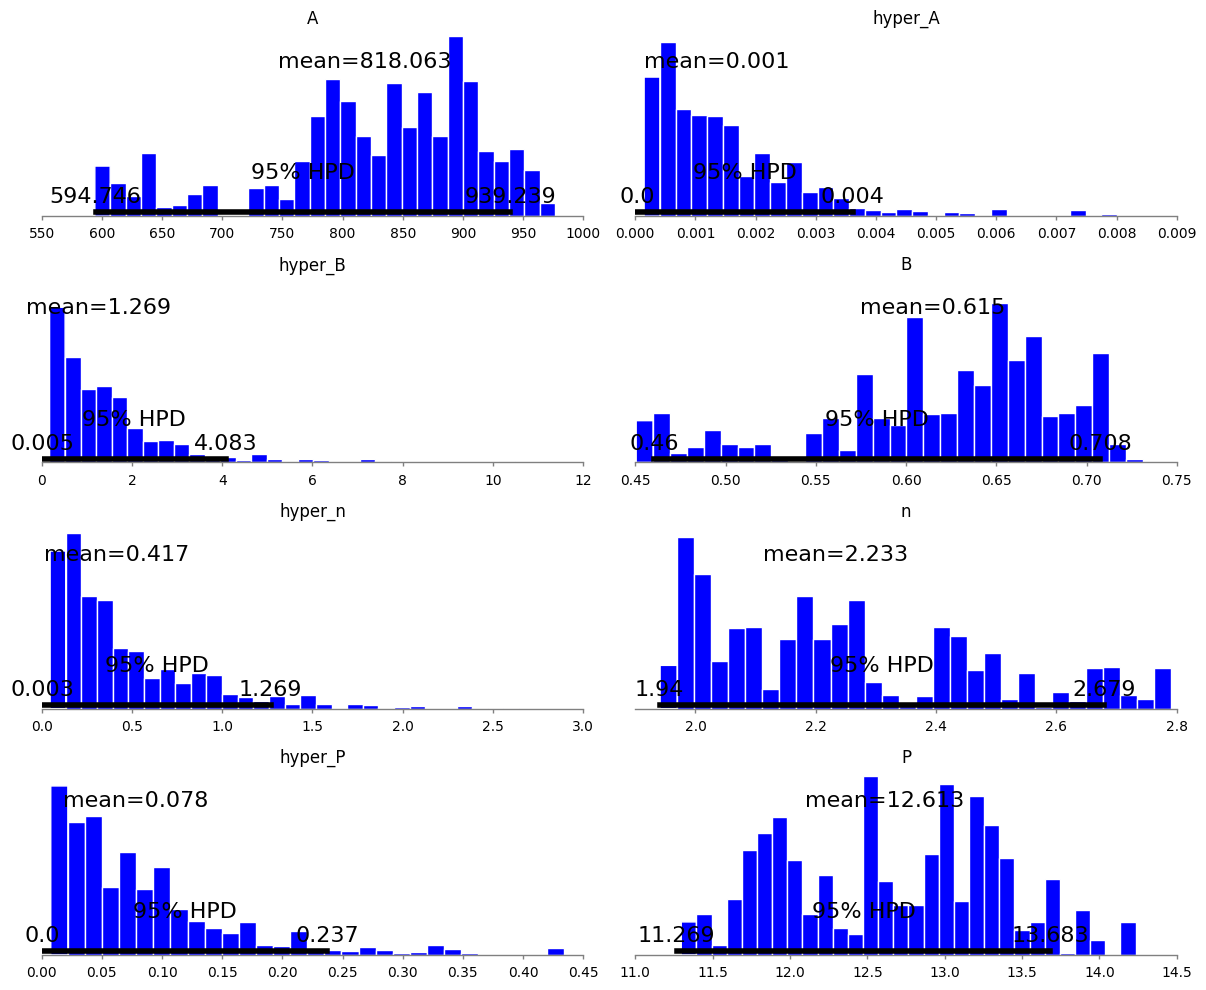

In [13]:
%matplotlib inline
trace = fit_and_plot(sideband_data['MultiJet'], 0, samples=2000, burn_period=1000, box='MultiJet')

In [14]:
get_nsigmas(trace, sideband_data['MultiJet'].ix[0], 'MultiJet')

1584 1553.39148857 33.3635697097 0.85
1635 1726.54533096 16.6533587661 0.0
675 687.493536161 12.0657297308 0.113
309 308.746496476 7.73580734949 0.513
259 236.772643144 13.7562743642 0.958
1006 936.002832938 8.95045284448 1.0
984 1015.49801588 15.092419004 0.065
390 390.387771251 11.3131711534 0.476
199 169.15559563 5.73625569196 1.0
131 122.104013644 6.40676808253 0.97
708 715.995626396 10.7019266074 0.181
504 511.173232212 14.0825428875 0.269
297 313.245791955 13.3983196314 0.047
78 75.3012603619 6.84521077779 0.686
15 14.8480807719 3.0222772249 0.52
2 0.497915767565 0.265858937914 1.0


{(500, 575, 0.25, 0.3): 1.0364333894937898,
 (500, 575, 0.3, 0.41): -inf,
 (500, 575, 0.41, 0.52): -1.2107271327915972,
 (500, 575, 0.52, 0.64): 0.032591936696663076,
 (500, 575, 0.64, 1.5): 1.7279343223884185,
 (575, 650, 0.25, 0.3): inf,
 (575, 650, 0.3, 0.41): -1.5141018876192835,
 (575, 650, 0.41, 0.52): -0.060195411728956635,
 (575, 650, 0.52, 0.64): inf,
 (575, 650, 0.64, 1.5): 1.8807936081512509,
 (650, 750, 0.25, 0.3): -0.91156073506754065,
 (750, 900, 0.25, 0.3): -0.61584018874797186,
 (900, 1200, 0.25, 0.3): -1.6746648890243256,
 (1200, 1600, 0.25, 0.3): 0.48454378244107893,
 (1600, 2500, 0.25, 0.3): 0.05015358346473367,
 (2500, 4000, 0.25, 0.3): inf}